In [11]:
from scipy.spatial import convex_hull_plot_2d, ConvexHull, HalfspaceIntersection
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
sys.path.append('../lu')
from src.polytope.region import create_graph_laplacian_matrix, estimate_p_hat, find_bounds
from src.polytope.region import generate_regions, create_faces, calculate_hyperplanes, create_M_matrix
from itertools import combinations
from collections import defaultdict

In [12]:
dceu_df = pd.read_csv("../dataset/dceu.csv")
movies_df = pd.read_parquet("../dataset/movies.parquet")
users_df = pd.read_parquet("../dataset/dceu_rotten_review.parquet").drop_duplicates()
users_df.title = users_df.title.str.strip()

In [13]:
movies_df.index.drop_duplicates()

Index(['Heartfall Arises', 'Isle of Dogs', 'The Family Stone',
       'Shanghai Dreams', 'Meet the Fockers', 'Restless', 'Race',
       'Scary Movie 4', 'The Good Lie', 'To All the Boys I've Loved Before',
       ...
       'Freedom Writers', 'The Suicide Forecast', 'Uncorked', 'The Punisher',
       'Set Me Free', 'I Am David', 'The Killing of a Sacred Deer', 'Lawless',
       'One Night with the King', 'Life of the Party'],
      dtype='object', name='title', length=4266)

In [14]:
users_to_ratings = defaultdict(dict)
movies_to_users = defaultdict(set)
for _, row in users_df.iterrows():
    users_to_ratings[row.reviewer][row.title] = row.score
    movies_to_users[row.title].add(row.reviewer)

In [15]:
items = np.array(movies_df.loc[dceu_df.title]["2d_embed"].apply(list).tolist())
m = len(items)
faces = create_faces(-1, 1, 2)
pairs = np.array(list(map(list, combinations(range(m), 2))))
accepted = []
for i, (left, right) in enumerate(pairs):
    left_movie, right_movie = dceu_df.iloc[left].title, dceu_df.iloc[right].title
    n_p = len(movies_to_users[left_movie] & movies_to_users[right_movie])
    if n_p >= 200:
        accepted.append(i)
pairs = pairs[accepted]
hyperplanes = calculate_hyperplanes(items, pairs)
regions = generate_regions(hyperplanes, faces)
full_regions = regions
M, _ = create_M_matrix(regions, hyperplanes)
L = create_graph_laplacian_matrix(regions,
                                  M,
                                  lambda x: 1 / x)

In [16]:
n_h = len(hyperplanes)
n_h

9

In [17]:
n_p = 50

In [18]:
list_of_movies = list(dceu_df.title.unique())

In [19]:
np.random.seed(0)
p_hats = defaultdict(list)
for method in ["least-square-graph"]:
    for _ in range(10):
        asked_users = set()
        q = []
        V = []
        for left, right in pairs:
            left_movie, right_movie = dceu_df.iloc[left].title, dceu_df.iloc[right].title
            users = np.array(list(movies_to_users[left_movie] & movies_to_users[right_movie]))
            np.random.shuffle(users)
            samples = []
            for user in users:
                if len(samples) == n_p:
                    break
                if user in asked_users:
                    continue
                asked_users.add(user)
                samples.append(user)

            if len(samples) < n_p:
                print("Warning: not enough samples")

            total = 0
            num_left = 0
            for user in samples:
                if users_to_ratings[user][left_movie] >= users_to_ratings[user][right_movie]:
                    v = []
                    v.append(f'{list_of_movies.index(left_movie)} > {list_of_movies.index(right_movie)}')
                    num_left += 1
                total += 1
                V.append(v)
            q.append(num_left / total)
        q.append(1)
        q_hat = np.array(q).reshape(-1, 1)
        p_hat = estimate_p_hat(M, q_hat, L, 1, -1, method=method)[0].reshape(-1, 1)
        p_lower, p_upper = find_bounds(q_hat, p_hat, M, n_h, n_p, 0.1)
        p_hat = p_hat.reshape(-1)
        for i in range(len(p_hat)):
            p_hats["region ID"].append(i)
            p_hats["probability"].append(p_hat[i])
            # p_hats["p_lower"].append(p_lower[i])
            # p_hats["p_upper"].append(p_upper[i])
            p_hats["method"].append(method)

/var/folders/0b/gtjn2bqj7hl7mth2hd2ybr700000gn/T/ipykernel_7931/312674185.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


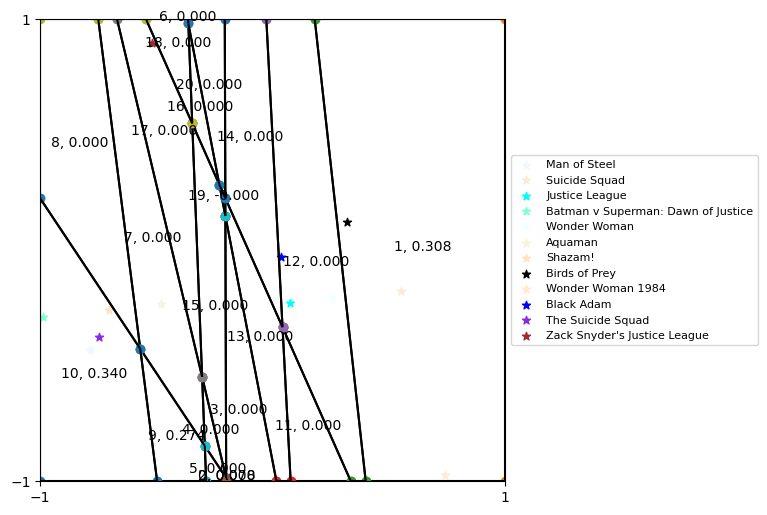

In [20]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
lb = -1
ub = 1
colors = list(mcolors.CSS4_COLORS.values())

for i, region in enumerate(regions):
    center = region.center
    hs = HalfspaceIntersection(region.hyperplanes, center)
    ch = ConvexHull(hs.intersections)
    convex_hull_plot_2d(ch, ax)
    center = hs.intersections.mean(axis=0)

    ax.text(
        center[0],
        center[1],
        f'{i}, {p_hat.reshape(-1)[i]:.3f}', horizontalalignment="center")

for i, (x, y) in enumerate(items):
    ax.scatter(x, y, c=colors[i], marker="*", label=dceu_df.iloc[i].title)

ax.set_xlim([lb, ub])
ax.set_xticks([lb, ub])
ax.set_ylim([lb, ub])
ax.set_yticks([lb, ub])
ax.legend(fontsize=8, loc="center left", bbox_to_anchor=(1, 0.5))
fig.savefig(f"fig/dceu_polytopes.pdf", dpi=600, format="pdf", bbox_inches="tight")
fig.show()